# Twitter Sentiment Analysis Using Classical & Neural Models

## 1. Introduction
This project studies sentiment classification on Twitter using the Kaggle "Twitter Sentiment Dataset" (Saurabh Shahane, 2021). The dataset contains cleaned tweets (`clean_text`) and sentiment labels in `category` with values -1 (negative), 0 (neutral), +1 (positive). The goal is to compare classical machine learning models against a text-oriented neural model (CNN–LSTM hybrid) and identify which approach is best for multiclass sentiment classification in terms of accuracy and robust F1 (macro).


## 🎯 Research Questions Addressed
1. Which model achieves the best overall and per-class performance for predicting sentiment?
2. How do TF-IDF and Word2Vec features compare when used with classical models?
3. Does a CNN–LSTM hybrid outperform classical ensembles (Voting Classifier) on this dataset?

## 3. Dataset
- Source: Kaggle — Twitter Sentiment Dataset (Saurabh Shahane, 2021).
- Columns: `clean_text` (string), `category` (int: -1, 0, 1).
- Size: (162980, 2)

In [5]:

import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import os

# Text processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
try:
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    print('nltk data downloaded successfully.')
except LookupError:
    print('FAILED nltk data downloaded.')

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Classical ML models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D,
                                     LSTM, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


[nltk_data] Downloading package punkt_tab to /home/bermar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bermar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-11-19 20:35:55.748620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 20:35:55.770695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


nltk data downloaded successfully.


2025-11-19 20:35:56.318745: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
DATA_PATH = 'twitter_data.csv'
SAMPLE_SIZE = 1000 # Set to an integer for sampling, or None for full dataset

In [7]:
print("\n" + "=" * 80)
print("TWITTER SENTIMENT ANALYSIS PIPELINE")
print("=" * 80)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    


TWITTER SENTIMENT ANALYSIS PIPELINE
Started at: 2025-11-19 20:36:04


In [48]:
   
data_path = DATA_PATH
random_state = 42
sample_size = SAMPLE_SIZE
df = None
X_train = None
X_test = None
y_train = None
y_test = None
models = {}
results = {}
stop_words = set(stopwords.words('english'))

# 1. Load data
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head(3))



Dataset shape: (162980, 2)
Columns: ['clean_text', 'category']

First 5 rows:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0


In [49]:
# 2. Perform EDA

"""Perform Exploratory Data Analysis"""
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Basic info
print("\n1. Dataset Info:")
print(df.info())

# Missing values
print(f"\n2. Missing values:\n{df.isnull().sum()}")

# Class distribution
print("\n3. Sentiment Distribution:")
sentiment_counts = df['category'].value_counts().sort_index()
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for cat, count in sentiment_counts.items():
    cat_int = int(cat)  # Convert float to int for display
    percentage = (count / len(df)) * 100
    print(f"   {sentiment_map.get(cat_int, 'Unknown'):10s} ({cat_int:2d}): {count:6d} ({percentage:5.2f}%)")

# Text length analysis
df['text_length'] = df['clean_text'].fillna('').apply(len)
df['word_count'] = df['clean_text'].fillna('').apply(lambda x: len(str(x).split()))

print("\n4. Text Statistics:")
print(f"   Average text length: {df['text_length'].mean():.2f} characters")
print(f"   Average word count: {df['word_count'].mean():.2f} words")
print(f"   Max text length: {df['text_length'].max()} characters")
print(f"   Min text length: {df['text_length'].min()} characters")


EXPLORATORY DATA ANALYSIS

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None

2. Missing values:
clean_text    4
category      7
dtype: int64

3. Sentiment Distribution:
   Negative   (-1):  35510 (21.79%)
   Neutral    ( 0):  55213 (33.88%)
   Positive   ( 1):  72250 (44.33%)

4. Text Statistics:
   Average text length: 124.17 characters
   Average word count: 20.08 words
   Max text length: 274 characters
   Min text length: 0 characters


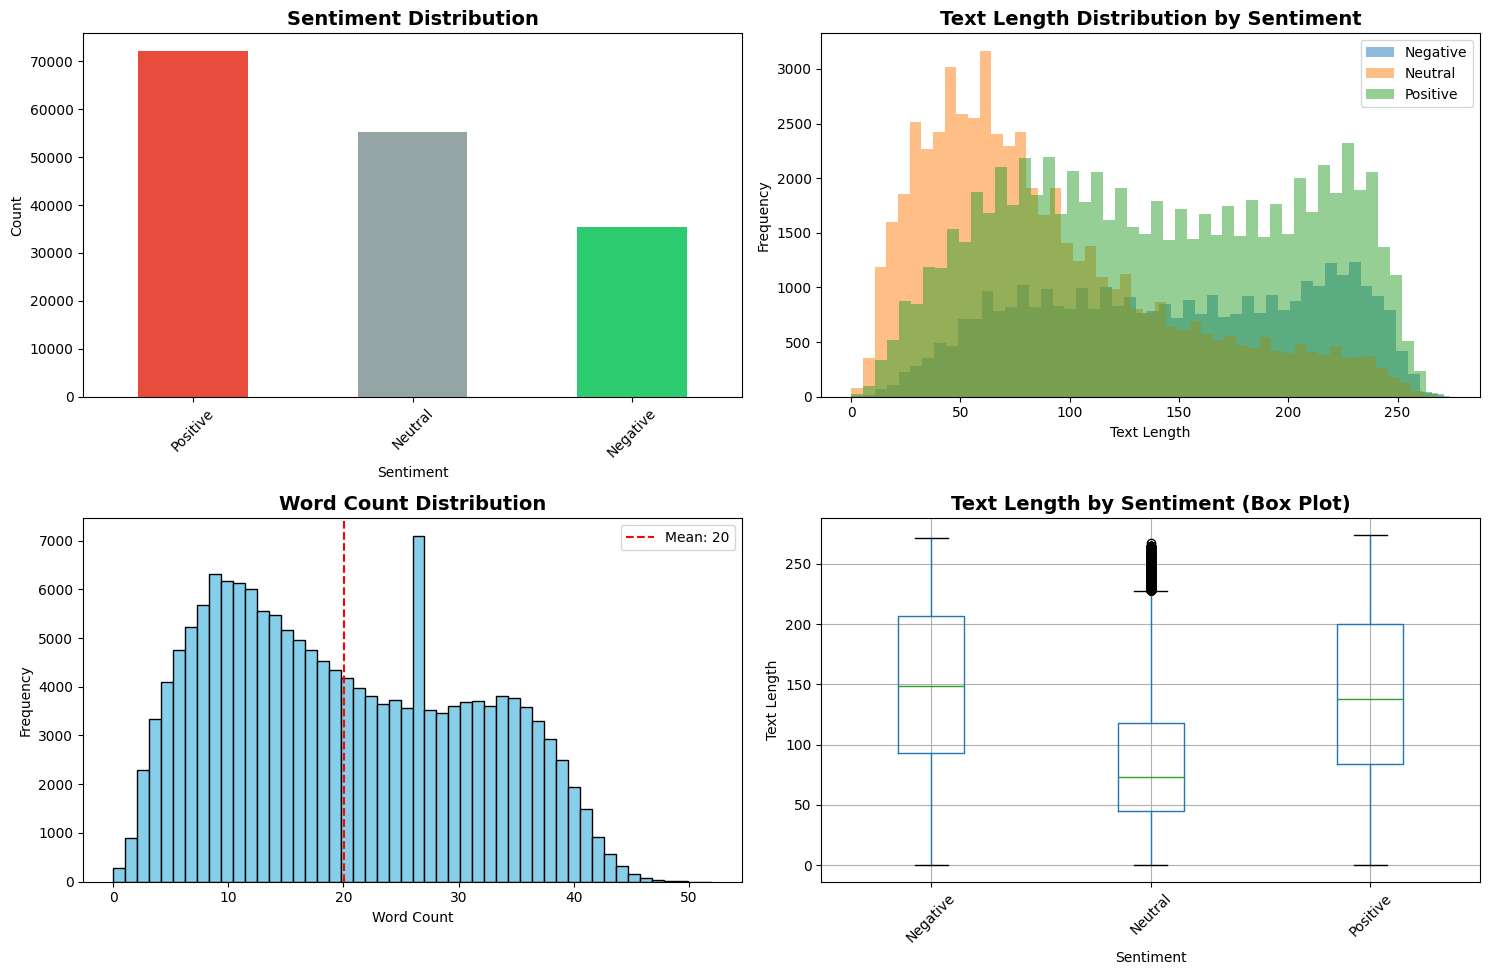

In [50]:
# Visualizations
"""Create EDA visualizations"""
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
df['sentiment_label'] = df['category'].map(sentiment_map)

ax1 = axes[0, 0]
df['sentiment_label'].value_counts().plot(kind='bar', ax=ax1, color=['#e74c3c', '#95a5a6', '#2ecc71'])
ax1.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Text length distribution by sentiment
ax2 = axes[0, 1]
for sentiment in ['Negative', 'Neutral', 'Positive']:
    subset = df[df['sentiment_label'] == sentiment]['text_length']
    ax2.hist(subset, alpha=0.5, label=sentiment, bins=50)
ax2.set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

# Word count distribution
ax3 = axes[1, 0]
ax3.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
ax3.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Frequency')
ax3.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
ax3.legend()

# Box plot of text length by sentiment
ax4 = axes[1, 1]
df.boxplot(column='text_length', by='sentiment_label', ax=ax4)
ax4.set_title('Text Length by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Text Length')
plt.sca(ax4)
plt.xticks(rotation=45)

plt.suptitle('')  # Remove the default title
plt.tight_layout()
plt.show()

In [51]:
# 3. Preprocess data
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)


def preprocess_data(df):
    """Preprocess the entire dataset"""
    print("\n" + "=" * 80)
    print("DATA PREPROCESSING")
    print("=" * 80)
    
    # Handle missing values
    print("Handling missing values...")
    original_len = len(df)
    df = df.dropna()
    removed = original_len - len(df)
    print(f"Removed {removed} empty texts")

    df['clean_text'] = df['clean_text'].fillna('')
    
    # Apply preprocessing
    print("Preprocessing text (this may take a while)...")
    df['processed_text'] = df['clean_text'].apply(preprocess_text)

    # Remove empty texts after preprocessing
    original_len = len(df)
    df = df[df['processed_text'].str.len() > 0]
    removed = original_len - len(df)
    print(f"Removed {removed} empty texts after preprocessing")
    
    print(f"Final dataset shape: {df.shape}")
        

df = preprocess_data(df)


DATA PREPROCESSING
Handling missing values...
Removed 11 empty texts
Preprocessing text (this may take a while)...


/tmp/ipykernel_173046/3152847040.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].fillna('')


Removed 66 empty texts after preprocessing
Final dataset shape: (162903, 6)


/tmp/ipykernel_173046/3152847040.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'] = df['clean_text'].apply(preprocess_text)


In [52]:
# 3.5. Sample dataset if specified (for faster development/testing)
sample_size = sample_size

# Ensure we don't sample more than available
actual_sample_size = min(sample_size, len(df))

print("\n" + "=" * 80)
print("DATASET SAMPLING FOR FASTER PROCESSING")
print("=" * 80)
print(f"Original dataset size: {len(df):,} samples")
print(f"Sampling to: {actual_sample_size:,} samples")

# Check if we have enough samples per class for stratified sampling
if actual_sample_size > len(df):
    actual_sample_size = len(df)
    print(f"Adjusted sample size to available data: {actual_sample_size:,}")

category_counts = df['category'].value_counts()
required_classes = {-1, 0, 1}

# Find the count of the minority class (N_min)
min_samples = category_counts.min()

# Calculate the maximum perfectly balanced total size (N_balanced_max)
N_balanced_max = min_samples * len(required_classes)
# Calculate the count required per class to meet actual_sample_size
N_per_class_desired = actual_sample_size // len(required_classes)
N_target = min(min_samples, N_per_class_desired)
# The final size will be N_target * 3
final_balanced_size = N_target * len(required_classes)

# 2. Undersample each class to the minority size
balanced_df_list = []

for category in required_classes:
    # Check if the category exists in the DataFrame to prevent errors
    if category in category_counts.index:
        category_df = df[df['category'] == category]

        # Randomly sample 'min_samples' from this category
        sampled_category_df = category_df.sample(
            n=N_target,
            random_state=random_state
        )
        balanced_df_list.append(sampled_category_df)

# 3. Combine the sampled datasets and shuffle
if balanced_df_list:
    df = pd.concat(balanced_df_list).sample(
        frac=1, # Sample 100% of the combined data to shuffle it
        random_state=random_state
    ).reset_index(drop=True)

print(f"\nTarget count per class for balancing: {N_target}")
print(f"Final dataset size adjusted to: {final_balanced_size:,} samples (balanced)")

# Show new distribution
print("\nSampled dataset distribution:")
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
for cat in [-1, 0, 1]:
    count = (df['category'] == cat).sum()
    if count > 0:
        percentage = (count / len(self.df)) * 100
        print(f"   {sentiment_map[cat]:10s}: {count:6d} ({percentage:5.2f}%)")

print(f"\nNew working dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Store all results
all_results = {}

In [ ]:
# 4. TF-IDF Features Pipeline
print("\n" + "#" * 80)
print("TFIDF FEATURE PIPELINE")
print("#" * 80)
X_train_tfidf, X_test_tfidf, y_train, y_test = self.prepare_tfidf_features()
tfidf_results = self.train_classical_models(
    X_train_tfidf, X_test_tfidf, y_train, y_test, 'tfidf'
)

In [ ]:
# Evaluate each TF-IDF model
for model_name, results in tfidf_results.items():
    eval_metrics = self.evaluate_model(
        y_test, results['predictions'], f"{model_name} (TF-IDF)"
    )
    tfidf_results[model_name].update(eval_metrics)

all_results['TF-IDF'] = tfidf_results

In [ ]:
# 5. Word2Vec Features Pipeline
print("\n" + "#" * 80)
print("WORD2VEC FEATURE PIPELINE")
print("#" * 80)
X_train_w2v, X_test_w2v, y_train, y_test = self.prepare_word2vec_features()
w2v_results = self.train_classical_models(
    X_train_w2v, X_test_w2v, y_train, y_test, 'word2vec'
)

In [ ]:
# Evaluate each Word2Vec model
for model_name, results in w2v_results.items():
    eval_metrics = self.evaluate_model(
        y_test, results['predictions'], f"{model_name} (Word2Vec)"
    )
    w2v_results[model_name].update(eval_metrics)

all_results['Word2Vec'] = w2v_results

In [ ]:
# 6. Neural Network Pipeline
print("\n" + "#" * 80)
print("NEURAL NETWORK PIPELINE")
print("#" * 80)
X_train_nn, X_test_nn, y_train_nn, y_test_nn, max_words, max_len = self.prepare_neural_network_data()
nn_results = self.train_neural_network(
    X_train_nn, X_test_nn, y_train_nn, y_test_nn, max_words, max_len
)

In [ ]:
# Evaluate neural network
eval_metrics = self.evaluate_model(
    nn_results['true_labels'], nn_results['predictions'], "CNN-LSTM Neural Network"
)
nn_results.update(eval_metrics)

all_results['Neural Network'] = {'CNN-LSTM': nn_results}

In [ ]:
# 7. Create comparison table
comparison_df = self.create_comparison_table(all_results)

In [ ]:
# 8. Plot ROC curves (for models with probability predictions)
self.plot_roc_curves(tfidf_results, y_test)

In [ ]:
# 10. Final summary
print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)
print(f"Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


# Identify best model
print("\n" + "=" * 80)
print("BEST MODEL")
print("=" * 80)
best_model_idx = comparison_df.iloc[0]
print(f"Best performing model: {best_model_idx['Model']} with {best_model_idx['Feature Type']} features")
print(f"  - Accuracy: {best_model_idx['Accuracy']}")
print(f"  - F1-Macro: {best_model_idx['F1-Macro']}")
